In [1]:
import pandas as pd
import warnings

from itertools import product
from tqdm import tqdm

from scipy import stats

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns

mpl.style.use('seaborn-muted')
sns.set(style="whitegrid")

In [3]:
warnings.simplefilter('ignore')

In [4]:
dfc = pd.read_json('data/hl-graph.json', lines=True)

In [5]:
dfa = pd.read_json('data/user-graph.json', lines=True)

In [6]:
DOMAINS = dfc.d1.unique()

In [7]:
DFC_METRICS = [c for c in dfc.columns if c.endswith('_scaled')]

In [8]:
DFA_METRICS = [c for c in dfa.columns if c.endswith('_scaled')]

In [9]:
def plot_domain_content(domain):
    
    pdf = dfc[dfc.d1==domain]
    pdf_melt = pdf.melt(['d1', 'd2'], DFC_METRICS)
    
    order = pdf_melt.groupby('d2').mean().sort_values('value', ascending=False).index
    plt.figure(figsize=(5,10))
    sns.barplot(x='value', y='d2', data=pdf_melt, hue='variable', order=order, linewidth=0)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
    plt.show()

In [10]:
def plot_domain_audience(domain):
    
    pdf = dfa[dfa.d1==domain]
    pdf_melt = pdf.melt(['d1', 'd2'], DFA_METRICS)
    
    order = pdf_melt.groupby('d2').mean().sort_values('value', ascending=False).index
    plt.figure(figsize=(5,10))
    sns.barplot(x='value', y='d2', data=pdf_melt, hue='variable', order=order, linewidth=0)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
    plt.show()

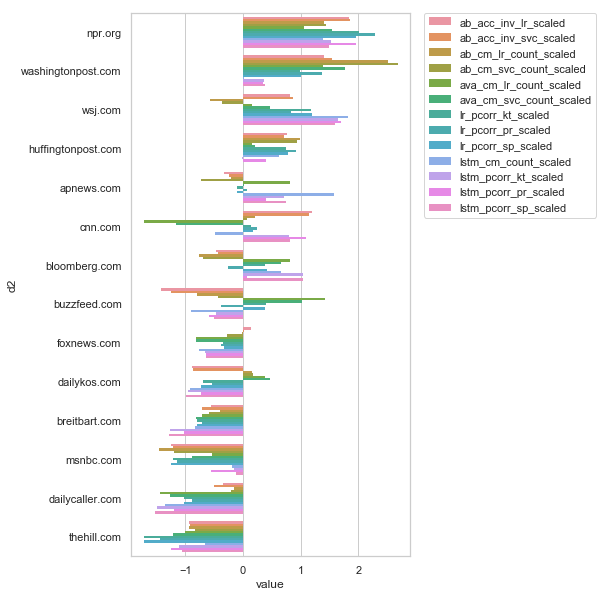

In [11]:
plot_domain_content('nytimes.com')

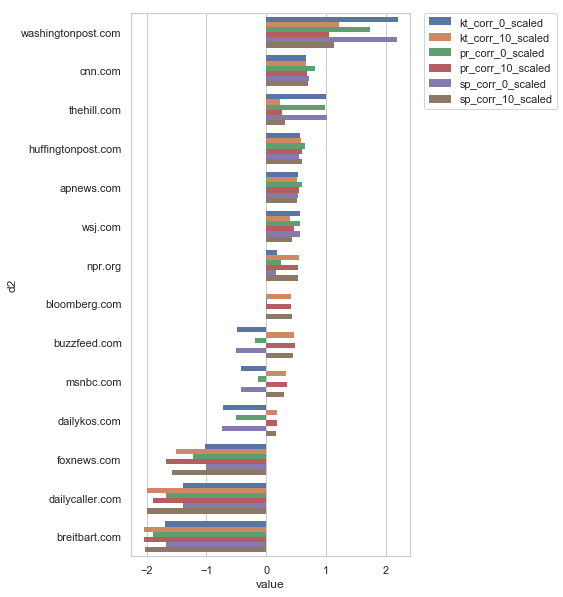

In [12]:
plot_domain_audience('nytimes.com')

In [13]:
def ca_corr(domain, c_metric, a_metric, plot=False):
    
    ddfc = dfc[dfc.d1==domain][['d2', c_metric]]
    ddfa = dfa[dfa.d1==domain][['d2', a_metric]]
    
    ddf = ddfc.merge(ddfa)
    
    if plot:
        ddf_melt = ddf.melt('d2', [c_metric, a_metric])
        order = ddf.sort_values(c_metric, ascending=False).d2
        plt.figure(figsize=(4,5))
        sns.barplot(y='d2', x='value', hue='variable', data=ddf_melt, order=order)
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
        plt.show()
    
    return stats.pearsonr(ddf[c_metric], ddf[a_metric])

In [15]:
rows = []
for d, cm, am in tqdm(product(DOMAINS, DFC_METRICS, DFA_METRICS)):
    corr, p = ca_corr(d, cm, am)
    rows.append((d, cm, am, corr, p))

1170it [00:04, 254.15it/s]


In [16]:
corr_df = pd.DataFrame(rows, columns=('domain', 'cm', 'am', 'corr', 'p'))

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

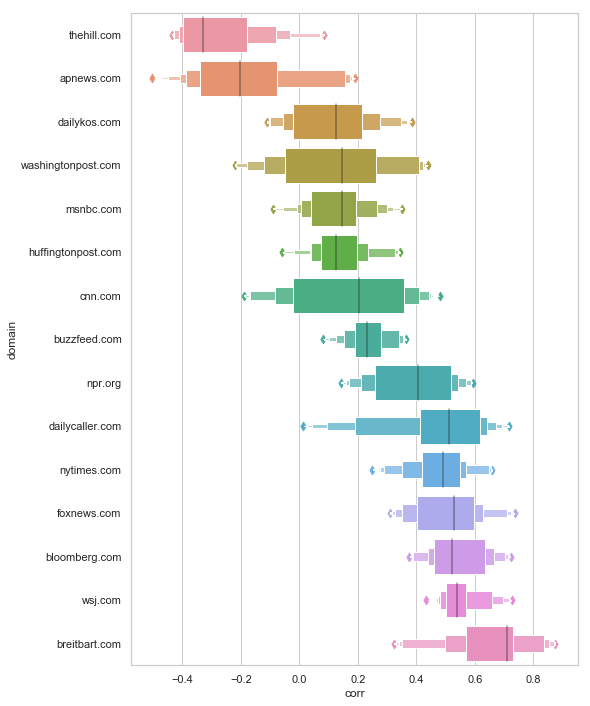

In [20]:
order = corr_df.groupby('domain').mean().sort_values('corr').index
plt.figure(figsize=(8,12))
sns.boxenplot(x='corr', y='domain', data=corr_df, order=order)

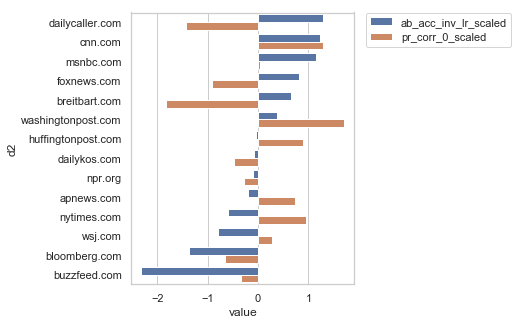

(-0.05412832356528325, 0.8541859362979556)

In [29]:
ca_corr('thehill.com', 'ab_acc_inv_lr_scaled', 'pr_corr_0_scaled', True)

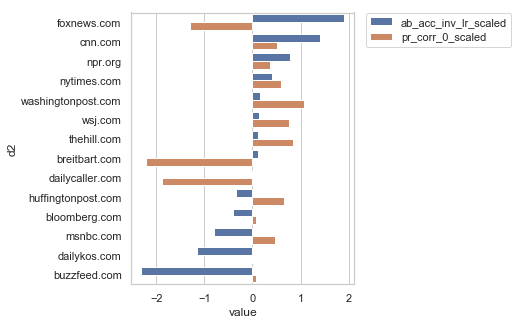

(-0.13038618979573327, 0.6568397942792631)

In [30]:
ca_corr('apnews.com', 'ab_acc_inv_lr_scaled', 'pr_corr_0_scaled', True)

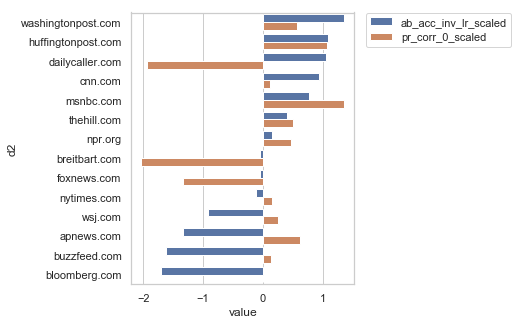

(0.01233177276453702, 0.9666259651535587)

In [31]:
ca_corr('dailykos.com', 'ab_acc_inv_lr_scaled', 'pr_corr_0_scaled', True)

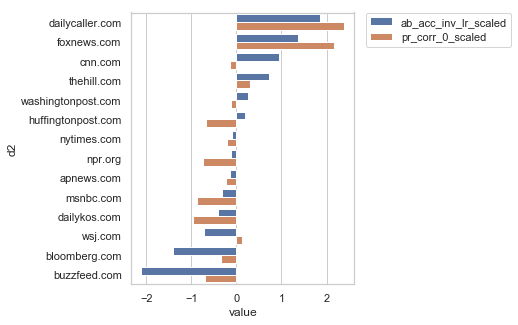

(0.710978491742612, 0.004362931167160104)

In [28]:
ca_corr('breitbart.com', 'ab_acc_inv_lr_scaled', 'pr_corr_0_scaled', True)